In [1]:
using Revise
includet("src/utils.jl")
includet("src/sources.jl")
using .utils: calc_prop, FluidPort, FluidProperties, SISO
using .sources: Source, Sink, Massflow

In [2]:
using ModelingToolkit, OrdinaryDiffEq
using ModelingToolkit: t_nounits as t, D_nounits as D
using ModelingToolkitStandardLibrary.Thermal: HeatPort
using CoolProp.CoolProp
using Plots

In [3]:
@mtkmodel Volume begin
    @parameters begin
        V
        h_init
        p_init
    end

    @components begin
        fluid_outlet = FluidPort()
    end

    begin
        fluid_model = fluid_outlet.fluid_model
        ρ_init = calc_prop(h_init, p_init, "HmassP_INPUTS", "D", fluid_model)
        T_init = calc_prop(h_init, p_init, "HmassP_INPUTS", "T", fluid_model)
        u_init = h_init - p_init/ρ_init
    end

    @variables begin
        h(t)
        p(t)
        ρ(t) = ρ_init
        m(t)
        u(t) = u_init
        T(t)
        Dm(t)
    end

    @equations begin
        # Conservation of mass
        D(m) ~ fluid_outlet.ṁ
        Dm ~ D(m)
        ρ ~ m/V

        # Conservation of energy
        D(u) ~ (fluid_outlet.ṁ*h - u*Dm)/m

        # State properties
        p ~ calc_prop(ρ, u, "DmassUmass_INPUTS", "P", fluid_model)
        T ~ calc_prop(ρ, u, "DmassUmass_INPUTS", "T", fluid_model)
        h ~ u + p/ρ

        # port connections
        fluid_outlet.h ~ h
        fluid_outlet.p ~ p
    end
end;

In [4]:
@mtkmodel TankSystem begin
    @structural_parameters begin
        fluid_model
    end

    @parameters begin
        V
        h_init
        p_init
        ṁ
    end

    @components begin
        # Fluid
        properties = FluidProperties(fluid_model=convert(Int32, fluid_model))
        volume = Volume(V=V, h_init=h_init, p_init=p_init)
        massflow = Massflow(ṁ=ṁ)
        sink = Sink()
    end

    @equations begin
        # Fluid
        connect(properties, volume.fluid_outlet)
        connect(volume.fluid_outlet, massflow.inlet)
        connect(massflow.outlet, sink.inlet)
    end
end;

In [5]:
## Inputs
# Fluid parameters
fluid_name = "ParaHydrogen"
eos = "HEOS"
fluid_model = AbstractState_factory(eos, fluid_name)
ṁ = -10e-3                 # kg/s
T_init = 28               # K
p_init = 16e5            # Pa
h_init = PropsSI("H", "T", T_init, "P", p_init, fluid_name);

# Tank parameters
V_tank = 0.5;        # m^3

In [6]:
@mtkbuild sys = TankSystem(; V=V_tank, h_init=h_init, p_init=p_init, ṁ=ṁ, fluid_model=fluid_model)

┌ Warning: fluid_outlet contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit C:\Users\matth\.julia\packages\ModelingToolkit\Ljerk\src\systems\connectors.jl:54
┌ Warning: inlet contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit C:\Users\matth\.julia\packages\ModelingToolkit\Ljerk\src\systems\connectors.jl:54
┌ Warning: outlet contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit C:\Use

Model sys:
Equations (2):
  2 standard: see equations(sys)
Unknowns (2): see unknowns(sys)
  volume₊m(t)
  volume₊u(t) [defaults to volume₊h_init + (-volume₊p_init) / calc_prop(volume₊h_init, volume₊p_init, HmassP_INPUTS, D, volume₊fluid_outlet₊fluid_model)]
Parameters (13): see parameters(sys)
  h_init [defaults to 1.03487e5]
  p_init [defaults to 1.6e6]
  volume₊V [defaults to V]
  volume₊h_init [defaults to h_init]
  volume₊p_init [defaults to p_init]
  ṁ [defaults to -0.01]
  ⋮
Observed (18): see observed(sys)

In [7]:
prob = ODEProblem(sys, [], (0, 3000.0));

In [8]:
sol = solve(prob, Tsit5(), dtmax=1.0);

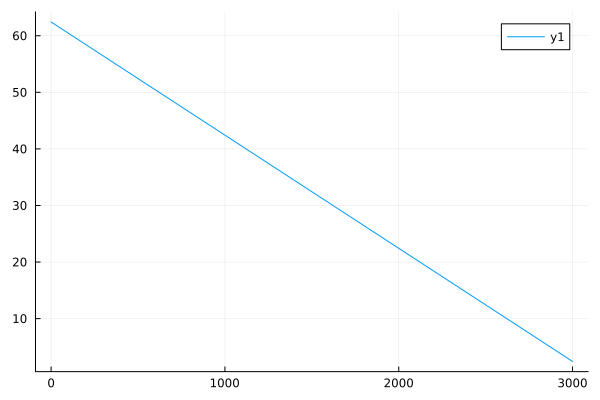

In [9]:
plot(sol.t, sol[sys.volume.ρ])

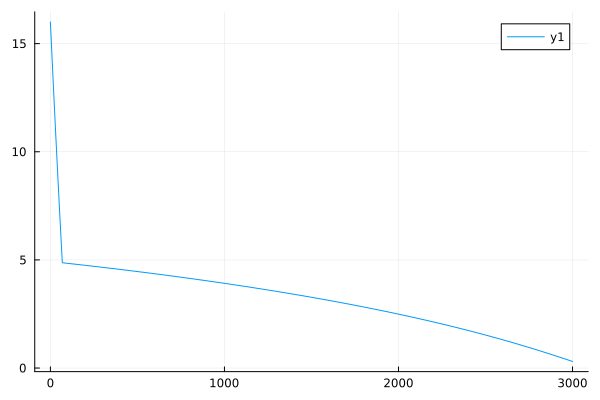

In [10]:
plot(sol.t, sol[sys.volume.p]/1e5)

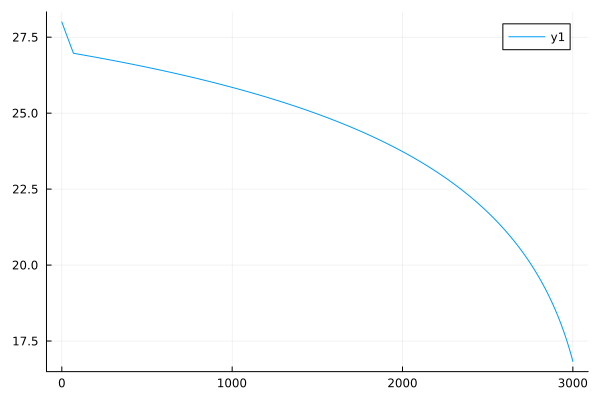

In [11]:
plot(sol.t, sol[sys.volume.T])

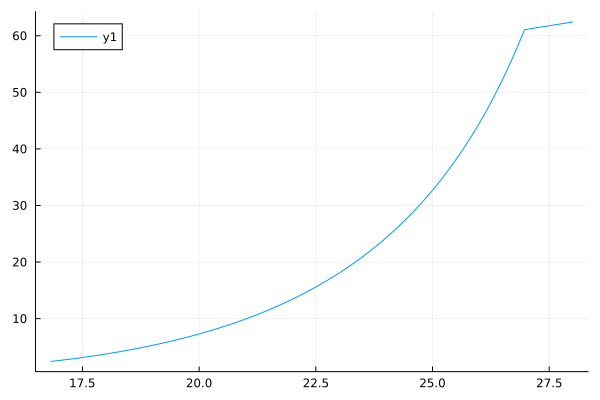

In [12]:
plot(sol[sys.volume.T], sol[sys.volume.ρ])

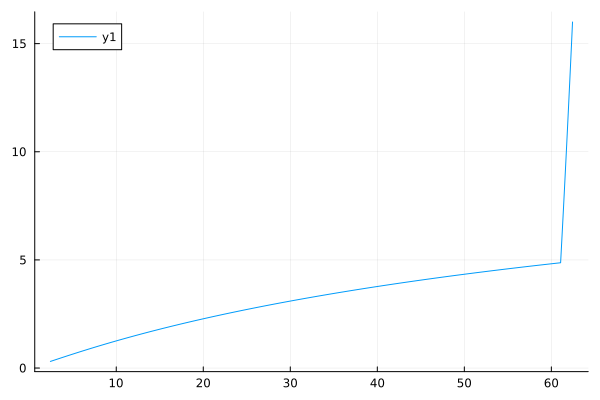

In [13]:
plot(sol[sys.volume.ρ], sol[sys.volume.p]/1e5)

In [14]:
println(sol[sys.volume.p][end]/1e5)
println(sol[sys.volume.T][end])

0.30684205357625344
16.828629965101502
